# 라이브러리 불러오기

In [40]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# EDA 지도 데이터용
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic


# 랜덤 시드 설정

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [4]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

## 금리, 공원, 학교, 지하철 불러오기

In [5]:
interest_data = pd.read_csv('data/interestRate.csv')
park_data = pd.read_csv('data/parkInfo.csv')
school_data = pd.read_csv('data/schoolinfo.csv')
subway_data = pd.read_csv('data/subwayInfo.csv')

In [6]:
train_data.head(10)

index  area_m2  contract_year_month  contract_day  contract_type  floor  \
0      0  84.9981               201906            25              2      9   
1      1  84.9981               202003            26              2     20   
2      2  84.9981               202003            28              2      8   
3      3  59.3400               201907            15              2      1   
4      4  59.8100               201904            12              2      6   
5      5  84.9342               201904            26              2     13   
6      6  39.2700               201905             7              2      3   
7      7  84.9342               201905             9              2      3   
8      8  84.9610               201905            25              2      3   
9      9  84.9182               201905            25              2     13   

   built_year   latitude   longitude  age  deposit  
0        2019  37.054314  127.045216    0  17000.0  
1        2019  37.054314  127.045216    1  23000.0  
2        2019  37.054314  127.045216    1  23000.0  
3        1986  36.964647  127.055847   33   5000.0  
4        1995  36.972390  127.084514   24   1800.0  
5        2016  36.965423  127.048779    3  20000.0  
6        1990  36.957089  127.047449   29   4000.0  
7        2016  36.965423  127.048779    3  20000.0  
8        2016  36.965423  127.048779    3  20500.0  
9        2016  36.965423  127.048779    3  19000.0

# 데이터 EDA 수행하기

## 지도 그려보기

In [7]:
# 결측치 확인
train_data.isna().sum()

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
deposit                0
dtype: int64

In [8]:
test_data.isna().sum()

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
dtype: int64

In [9]:
print(interest_data.isna().sum())
print(park_data.isna().sum())
print(school_data.isna().sum())
print(subway_data.isna().sum())

year_month       0
interest_rate    0
dtype: int64
latitude     0
longitude    0
area         0
dtype: int64
schoolLevel    0
latitude       0
longitude      0
dtype: int64
latitude     0
longitude    0
dtype: int64


In [10]:
# 중복되는 행만 추출 (모든 열 기준으로 중복 확인)
duplicate_rows = train_data[train_data.duplicated(subset=train_data.columns.difference(['index']),keep = False)]

# 중복된 행 출력
duplicate_rows



index   area_m2  contract_year_month  contract_day  contract_type  \
15            15   84.9342               201907            31              2   
16            16   84.9342               201907            31              2   
28            28  146.4005               201911            21              2   
29            29  146.4005               201911            21              2   
33            33   84.9342               201912            14              2   
...          ...       ...                  ...           ...            ...   
1801197  1801197  101.9088               202308            22              2   
1801198  1801198  114.9285               202308            28              1   
1801199  1801199  114.9285               202308            28              1   
1801210  1801210  114.9285               202310            26              2   
1801211  1801211  114.9285               202310            26              2   

         floor  built_year   latitude   longitude  age  deposit  
15           7        2016  36.965423  127.048779    3  18000.0  
16           7        2016  36.965423  127.048779    3  18000.0  
28           5        2016  36.965423  127.048779    3  37000.0  
29           5        2016  36.965423  127.048779    3  37000.0  
33          14        2016  36.965423  127.048779    3  19000.0  
...        ...         ...        ...         ...  ...      ...  
1801197     11        2010  37.528394  126.659398   13  33000.0  
1801198     18        2010  37.528394  126.659398   13  30000.0  
1801199     18        2010  37.528394  126.659398   13  30000.0  
1801210      9        2010  37.528394  126.659398   13  39000.0  
1801211      9        2010  37.528394  126.659398   13  39000.0  

[162417 rows x 11 columns]

부동산 계약에서 같은 주소가 같은 날 같은 가격으로 두 번 이상 계약되는 일은 없고 따라서 전처리가 필요합니다.

In [11]:
# index 열을 제외한 나머지 열들을 기준으로 중복되는 행 중 하나만 남기고 나머지 삭제
train_data = train_data.drop_duplicates(subset=train_data.columns.difference(['index']), keep='first')


# 중복되는 행만 추출 (모든 열 기준으로 중복 확인)
duplicate_rows = train_data[train_data.duplicated(subset=train_data.columns.difference(['index']),keep = False)]

# 중복된 행 출력
duplicate_rows



Empty DataFrame
Columns: [index, area_m2, contract_year_month, contract_day, contract_type, floor, built_year, latitude, longitude, age, deposit]
Index: []

### 기본적인 통계량 확인

In [12]:
train_data.describe()

index       area_m2  contract_year_month  contract_day  \
count  1.717611e+06  1.717611e+06         1.717611e+06  1.717611e+06   
mean   9.019507e+05  7.524180e+01         2.021336e+05  1.590339e+01   
std    5.193502e+05  2.558576e+01         1.353578e+02  8.629776e+00   
min    0.000000e+00  1.032150e+01         2.019040e+05  1.000000e+00   
25%    4.534005e+05  5.975010e+01         2.020080e+05  9.000000e+00   
50%    9.022850e+05  7.792000e+01         2.021110e+05  1.600000e+01   
75%    1.351972e+06  8.496000e+01         2.022120e+05  2.300000e+01   
max    1.801227e+06  3.173600e+02         2.023120e+05  3.100000e+01   

       contract_type         floor    built_year      latitude     longitude  \
count   1.717611e+06  1.717611e+06  1.717611e+06  1.717611e+06  1.717611e+06   
mean    1.201827e+00  1.004954e+01  2.004139e+03  3.747743e+01  1.269666e+02   
std     8.825039e-01  6.965997e+00  1.114347e+01  1.623614e-01  1.697936e-01   
min     0.000000e+00 -4.000000e+00  1.961000e+03  3.691791e+01  1.264787e+02   
25%     0.000000e+00  5.000000e+00  1.995000e+03  3.738028e+01  1.268431e+02   
50%     2.000000e+00  9.000000e+00  2.004000e+03  3.750246e+01  1.269977e+02   
75%     2.000000e+00  1.400000e+01  2.015000e+03  3.758211e+01  1.270887e+02   
max     2.000000e+00  6.800000e+01  2.024000e+03  3.818194e+01  1.276609e+02   

                age       deposit  
count  1.717611e+06  1.717611e+06  
mean   1.713041e+01  3.823133e+04  
std    1.111990e+01  2.617477e+04  
min   -3.000000e+00  3.000000e+02  
25%    7.000000e+00  2.100000e+04  
50%    1.700000e+01  3.200000e+04  
75%    2.600000e+01  4.800000e+04  
max    6.200000e+01  1.100000e+06

In [13]:
test_data.describe()

index        area_m2  contract_year_month   contract_day  \
count  150172.00000  150172.000000        150172.000000  150172.000000   
mean    75085.50000      74.509956        202403.137576      14.816650   
std     43351.06665      23.971424             1.645994       8.537693   
min         0.00000      10.780000        202401.000000       1.000000   
25%     37542.75000      59.760000        202402.000000       7.000000   
50%     75085.50000      75.793700        202403.000000      15.000000   
75%    112628.25000      84.958200        202405.000000      22.000000   
max    150171.00000     273.860000        202406.000000      31.000000   

       contract_type          floor     built_year       latitude  \
count  150172.000000  150172.000000  150172.000000  150172.000000   
mean        0.426071      10.060557    2004.908292      37.474571   
std         0.597423       6.982813      11.460352       0.166952   
min         0.000000      -3.000000    1966.000000      36.957089   
25%         0.000000       5.000000    1995.000000      37.372616   
50%         0.000000       9.000000    2004.000000      37.500382   
75%         1.000000      14.000000    2016.000000      37.588872   
max         2.000000      60.000000    2024.000000      38.106033   

           longitude            age  
count  150172.000000  150172.000000  
mean      126.967625      19.091708  
std         0.172066      11.460352  
min       126.478708       0.000000  
25%       126.841057       8.000000  
50%       126.998922      20.000000  
75%       127.091862      29.000000  
max       127.660896      58.000000

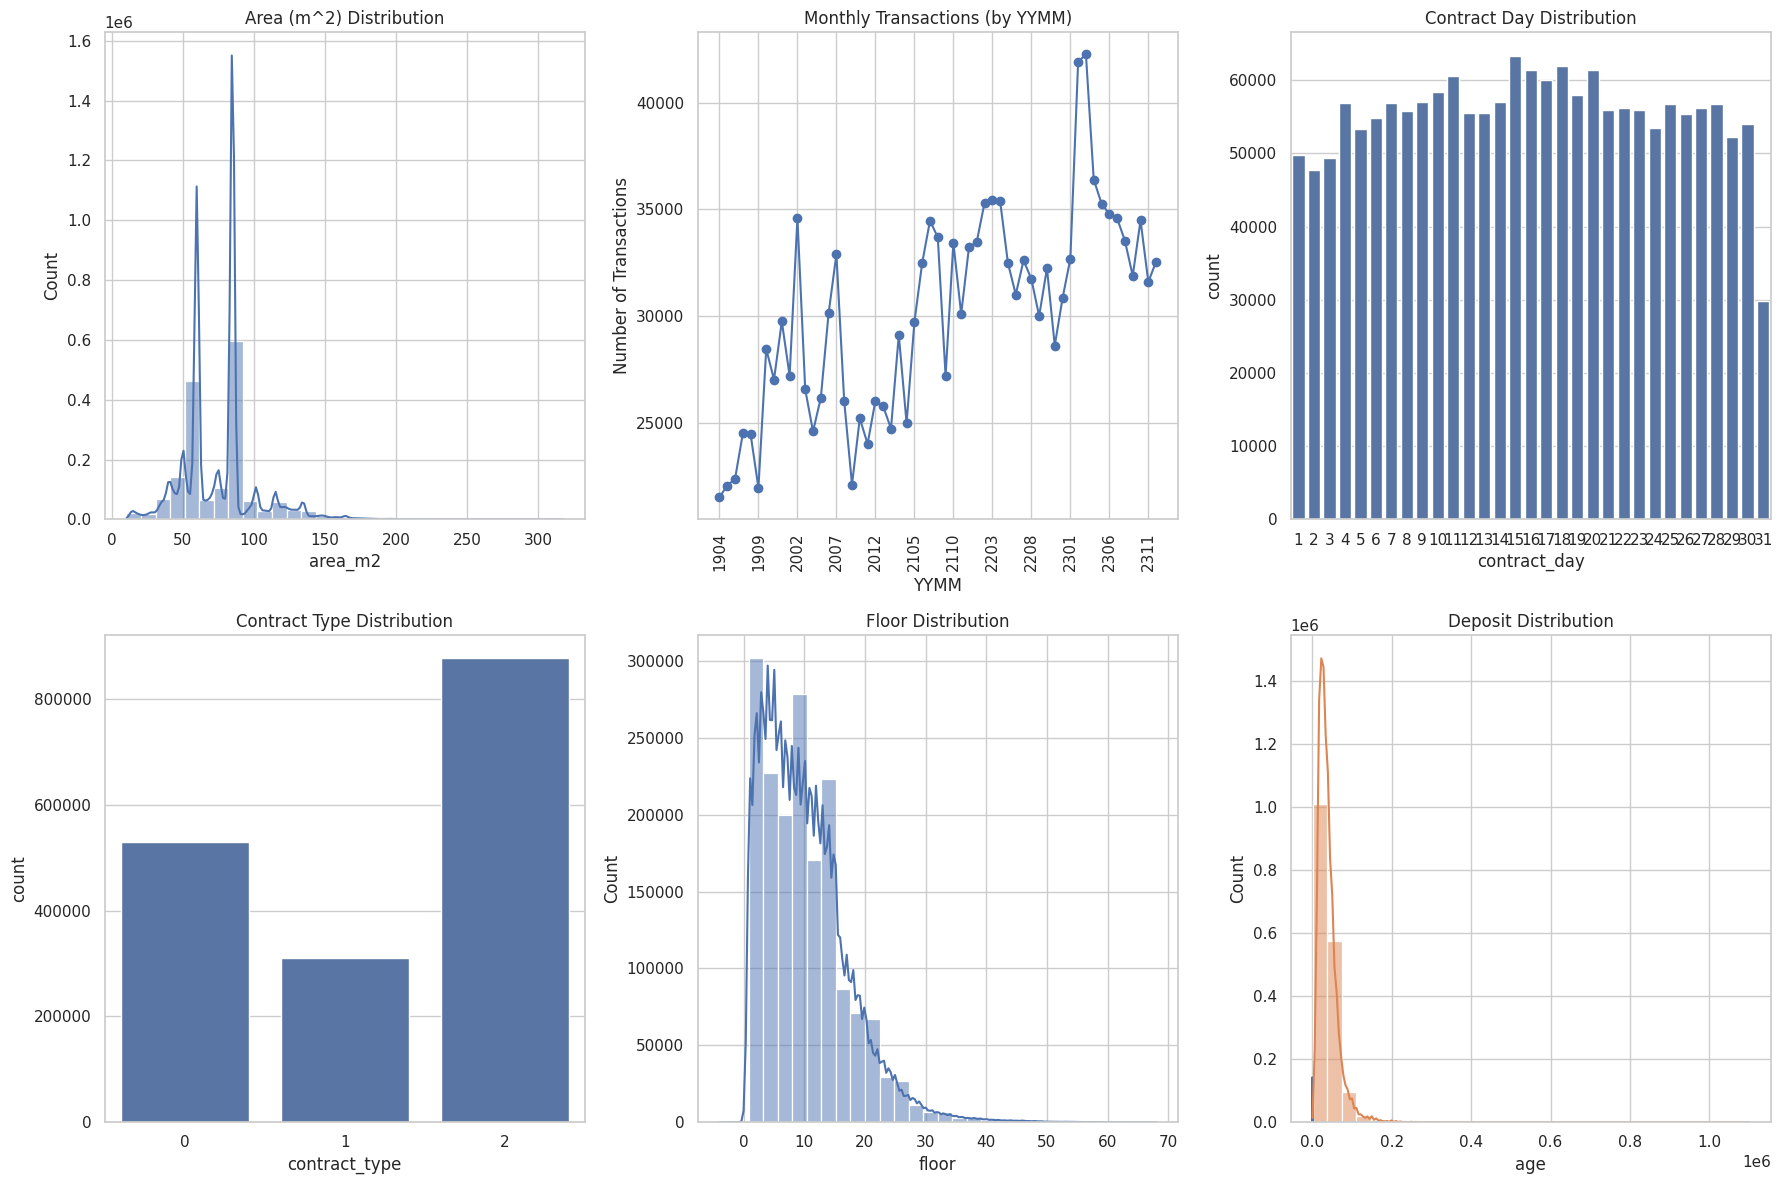

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 그래프를 여러 개 배치할 수 있는 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# 각 변수에 대해 분포 그리기
sns.histplot(train_data['area_m2'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Area (m^2) Distribution')

# contract_year_month를 "YYMM" 형식으로 변환
train_data['contract_year_month'] = train_data['contract_year_month'].astype(str)
train_data['YYMM'] = train_data['contract_year_month'].apply(lambda x: x[2:])

# 월별로 그룹화하고 거래량 계산
monthly_transactions = train_data.groupby('YYMM').size()

# 선그래프 그리기
axes[0, 1].plot(monthly_transactions.index, monthly_transactions.values, marker='o', linestyle='-')
axes[0, 1].set_title('Monthly Transactions (by YYMM)')
axes[0, 1].set_xlabel('YYMM')
axes[0, 1].set_ylabel('Number of Transactions')

# x축 레이블을 간격에 맞춰 표시 (간격을 조정하여 레이블을 줄임)
step = max(1, len(monthly_transactions) // 10)  # 10개의 레이블만 표시
axes[0, 1].set_xticks(axes[0, 1].get_xticks()[::step])
axes[0, 1].tick_params(axis='x', rotation=90)

sns.countplot(x=train_data['contract_day'], ax=axes[0, 2])
axes[0, 2].set_title('Contract Day Distribution')

sns.countplot(x=train_data['contract_type'], ax=axes[1, 0])
axes[1, 0].set_title('Contract Type Distribution')

sns.histplot(train_data['floor'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Floor Distribution')

sns.histplot(train_data['age'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Building Age Distribution')

# deposit 분포 추가
sns.histplot(train_data['deposit'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Deposit Distribution')

# 레이아웃 조정
plt.tight_layout()
plt.show()



### 이상치 확인

통계량 상 floor 와 age가 도메인 지식과 상응되는 점 확인 따라서, 분석이 더 필요합니다

In [15]:
# 나이가 0보다 작은 데이터 필터링
negative_age_data = train_data[train_data['age'] < -1]

# 고유한 latitude와 longitude 추출
unique_lat_long = negative_age_data[['latitude', 'longitude']].drop_duplicates()

# 고유한 latitude와 longitude 출력
unique_lat_long


latitude   longitude
6101     37.690500  127.211147
6153     37.690810  127.212458
20210    37.723645  127.057603
28858    37.022348  127.093319
31588    37.428620  126.998875
342909   37.001944  127.157404
445834   37.816934  127.056850
536611   37.270556  127.070720
537054   37.297819  127.119310
968419   37.618263  127.053335
987149   37.595555  126.923904
1027954  37.503153  126.907633
1112268  37.538617  127.082375
1168345  37.551166  126.949556
1309325  37.580081  126.903417

In [16]:
# 특정 위도와 경도 값
target_latitude = 37.618263
target_longitude = 127.053335


# np.isclose를 사용하여 근사값 비교로 데이터 필터링
specific_apartment_data = train_data[np.isclose(train_data['latitude'], target_latitude) & np.isclose(train_data['longitude'], target_longitude)]

specific_apartment_data.head(20)

index  area_m2 contract_year_month  contract_day  contract_type  \
968419    968419    84.97              201906            18              2   
968905    968905    59.92              201910            29              2   
968956    968956    59.92              201911            23              2   
1207526  1207526    59.92              202105             8              2   
1208161  1208161    59.92              202105            15              2   
1210271  1210271    59.92              202106            11              1   
1210364  1210364    59.92              202106            12              1   
1210768  1210768    59.92              202106            17              1   
1210861  1210861    59.92              202106            18              1   
1211206  1211206    59.92              202106            21              1   
1211339  1211339    59.92              202106            22              1   
1212304  1212304    84.97              202107             5              0   
1212688  1212688    84.97              202107            10              1   
1212847  1212847    84.97              202107            10              0   
1212871  1212871    59.92              202107            12              1   
1213506  1213506    84.97              202107            20              1   
1213994  1213994    84.97              202107            25              1   
1214800  1214800    84.97              202108             7              1   
1215106  1215106    84.97              202108            10              1   
1215188  1215188    59.92              202108            10              2   

         floor  built_year   latitude   longitude  age  deposit  YYMM  
968419      10        2021  37.618263  127.053335   -2  33000.0  1906  
968905       5        2019  37.618263  127.053335    0  35000.0  1910  
968956       8        2019  37.618263  127.053335    0  30000.0  1911  
1207526      6        2019  37.618263  127.053335    2  53000.0  2105  
1208161     15        2021  37.618263  127.053335    0  45000.0  2105  
1210271     21        2021  37.618263  127.053335    0  31500.0  2106  
1210364      6        2019  37.618263  127.053335    2  36750.0  2106  
1210768      8        2021  37.618263  127.053335    0  46000.0  2106  
1210861      9        2021  37.618263  127.053335    0  31500.0  2106  
1211206      5        2021  37.618263  127.053335    0  31500.0  2106  
1211339     14        2021  37.618263  127.053335    0  31500.0  2106  
1212304     25        2021  37.618263  127.053335    0  68500.0  2107  
1212688     19        2021  37.618263  127.053335    0  45000.0  2107  
1212847      5        2021  37.618263  127.053335    0  68000.0  2107  
1212871     18        2021  37.618263  127.053335    0  31500.0  2107  
1213506      8        2021  37.618263  127.053335    0  39900.0  2107  
1213994     23        2021  37.618263  127.053335    0  38800.0  2107  
1214800      8        2021  37.618263  127.053335    0  37800.0  2108  
1215106     23        2021  37.618263  127.053335    0  40950.0  2108  
1215188     16        2021  37.618263  127.053335    0  35700.0  2108

확인 결과 age가 - 인 데이터는 정상적. 입주 기간이 늦어지거나 공공 민간임대인 경우도 있고 건축 연도가 실제로 계약 시작일로부터 age만큼 후랑 맞음

In [18]:
# 층이 0보다 작은 데이터 필터링
train_data[train_data['floor'] <= 0].shape



(66, 12)

확인결과 0 이하 의 개수는 66개, 십만개의 데이타에 비하면 굉장히 적지만 확인 필요

In [19]:
# 층이 0 이하인 데이터 필터링
low_floor_data = train_data[train_data['floor'] <= 0]

# 같은 위도, 경도, 면적을 가진 다른 거래와 비교하기 위해 데이터 그룹화
# floor가 0 이하인 거래의 고유한 위도, 경도, 면적 추출
unique_properties = low_floor_data[['latitude', 'longitude', 'area_m2']].drop_duplicates()

# 결과를 저장할 리스트
comparison_results = []

# 고유한 위도, 경도, 면적을 가진 다른 거래와 비교
for index, row in unique_properties.iterrows():
    # 같은 위도, 경도, 면적을 가진 모든 거래 추출
    similar_transactions = train_data[
        (train_data['latitude'] == row['latitude']) &
        (train_data['longitude'] == row['longitude']) &
        (train_data['area_m2'] == row['area_m2'])
    ]
    
    # 층이 0 이하인 거래와 층이 0보다 큰 거래의 보증금 차이를 계산
    low_floor_deposit = similar_transactions[similar_transactions['floor'] <= 0]['deposit'].mean()
    other_floor_deposit = similar_transactions[similar_transactions['floor'] > 0]['deposit'].mean()
    
    # 차이를 계산하여 저장
    deposit_difference = low_floor_deposit - other_floor_deposit
    comparison_results.append({
        'latitude': row['latitude'],
        'longitude': row['longitude'],
        'area_m2': row['area_m2'],
        'low_floor_deposit': low_floor_deposit,
        'other_floor_deposit': other_floor_deposit,
        'deposit_difference': deposit_difference
    })

# 비교 결과를 데이터프레임으로 변환
comparison_df = pd.DataFrame(comparison_results)

# 결과 출력
comparison_df


latitude   longitude  area_m2  low_floor_deposit  other_floor_deposit  \
0   37.374628  127.114846   84.900            64000.0         68863.537736   
1   37.593130  127.142876   59.310            20000.0         24000.000000   
2   37.295999  127.153425   84.960            43000.0                  NaN   
3   37.551136  126.974959   20.960             7500.0                  NaN   
4   37.523559  126.959247   58.580            13000.0         22200.000000   
5   37.637105  126.928169  134.710            69500.0                  NaN   
6   37.563496  126.954801   97.030            40000.0         36916.666667   
7   37.572963  126.928727   83.490            18000.0                  NaN   
8   37.483197  126.844729   84.780            44000.0                  NaN   
9   37.486550  126.840182   84.950            55000.0                  NaN   
10  37.476188  126.904588   95.185            16000.0                  NaN   
11  37.487864  127.043825  213.940           350000.0                  NaN   
12  37.613021  126.933779  125.380            71000.0         73000.000000   
13  37.613021  126.933779   95.490            67000.0                  NaN   
14  37.483197  126.844729   84.950            53500.0         49500.000000   
15  37.553514  126.944932   75.060            45000.0                  NaN   
16  37.607004  126.957327  140.040            47500.0                  NaN   
17  37.547574  127.012878   76.660            81750.0                  NaN   
18  37.590628  127.003123  198.810           100000.0                  NaN   
19  37.637105  126.928169  134.460            62000.0                  NaN   
20  37.637105  126.928169  101.970            49725.0                  NaN   
21  37.556246  126.982537   27.100            12500.0                  NaN   
22  37.610887  127.002392   51.170             2800.0                  NaN   
23  37.537751  126.861309  102.370            47500.0         31000.000000   
24  37.590013  126.948494   67.240            63000.0                  NaN   
25  37.523559  126.959247   65.550            30000.0         19906.250000   
26  37.550755  127.006461   59.900            18000.0                  NaN   
27  37.550872  127.005462   53.880            13650.0         22000.000000   
28  37.549443  126.975527   73.600            26700.0                  NaN   
29  37.549443  126.975527   82.770            31000.0                  NaN   
30  37.578220  127.021672   60.000            26000.0                  NaN   
31  37.637105  126.928169  134.790            80000.0                  NaN   
32  37.551007  127.005238   55.730            22000.0         23000.000000   
33  37.507879  126.916674   84.990            70000.0                  NaN   
34  37.550872  127.005462   38.930            13000.0         13000.000000   
35  37.523559  126.959247   66.080            17000.0         20117.307692   
36  37.576722  127.019720   59.560            40000.0                  NaN   
37  37.542460  126.964273  111.920            64000.0                  NaN   
38  37.573225  126.929588   33.060             5250.0                  NaN   
39  37.541541  126.966886  130.930            65000.0         66750.000000   
40  37.551121  127.005577   29.400             6500.0          9000.000000   
41  37.550705  127.005566   59.950            12000.0         16000.000000   
42  37.550376  127.005442   59.990            13000.0         15000.000000   
43  37.534703  127.009230   28.300            10000.0                  NaN   
44  37.614333  127.040002   80.550            13000.0                  NaN   
45  37.637105  126.928169  134.510            75000.0                  NaN   

    deposit_difference  
0         -4863.537736  
1         -4000.000000  
2                  NaN  
3                  NaN  
4         -9200.000000  
5                  NaN  
6          3083.333333  
7                  NaN  
8                  NaN  
9                  NaN  
10                 NaN  
11                 NaN  
12        -20

In [41]:
# latitude longitude 기준으로 아파트 거래량 계산
apartment_frequency = train_data.groupby(['latitude', 'longitude']).size().reset_index(name='frequency')
# 빈도 기준 정렬
apartment_frequency_sorted = apartment_frequency.sort_values(by='frequency', ascending=False)
apartment_frequency_sorted.head(10)

latitude   longitude  frequency
16883  37.654629  127.340430       5013
8470   37.497618  127.107260       3627
10261  37.521233  127.108648       3109
8481   37.497741  127.065070       2756
9698   37.513305  127.081596       2646
451    37.113681  126.910849       2501
17543  37.694017  126.762857       2422
9703   37.513393  127.086817       2361
9836   37.515759  127.093939       2354
9899   37.516691  127.137712       2293

In [72]:
# 특정 위도와 경도 값
target_latitude = 37.497618
target_longitude = 127.107260

# np.isclose를 사용하여 근사값 비교로 데이터 필터링
specific_apartment_data = train_data[np.isclose(train_data['latitude'], target_latitude) & np.isclose(train_data['longitude'], target_longitude)]

# 해당 아파트 데이터에 대한 통계량 확인
apartment_statistics = specific_apartment_data.describe(include='all')

# 결과 출력
apartment_statistics



index      area_m2  contract_year_month  contract_day  \
count  3.627000e+03  3627.000000          3627.000000   3627.000000   
mean   1.263934e+06    78.119694        202156.442514     16.025917   
std    1.603395e+05    20.700854           131.007805      8.424408   
min    1.058471e+06    39.100000        201904.000000      1.000000   
25%    1.096126e+06    59.960000        202101.000000      9.000000   
50%    1.226568e+06    84.980000        202112.000000     16.000000   
75%    1.376038e+06    84.990000        202302.000000     23.000000   
max    1.523575e+06   150.090000        202312.000000     31.000000   

       contract_type        floor  built_year      latitude     longitude  \
count    3627.000000  3627.000000      3627.0  3.627000e+03  3.627000e+03   
mean        1.189964    14.402537      2018.0  3.749762e+01  1.271073e+02   
std         0.880962     8.741276         0.0  7.106407e-15  2.842563e-14   
min         0.000000     1.000000      2018.0  3.749762e+01  1.271073e+02   
25%         0.000000     7.000000      2018.0  3.749762e+01  1.271073e+02   
50%         2.000000    13.000000      2018.0  3.749762e+01  1.271073e+02   
75%         2.000000    21.000000      2018.0  3.749762e+01  1.271073e+02   
max         2.000000    35.000000      2018.0  3.749762e+01  1.271073e+02   

               age        deposit  
count  3627.000000    3627.000000  
mean      3.503171   87273.064792  
std       1.316943   25690.615356  
min       1.000000    5000.000000  
25%       3.000000   69000.000000  
50%       3.000000   84000.000000  
75%       5.000000  100000.000000  
max       5.000000  240000.000000

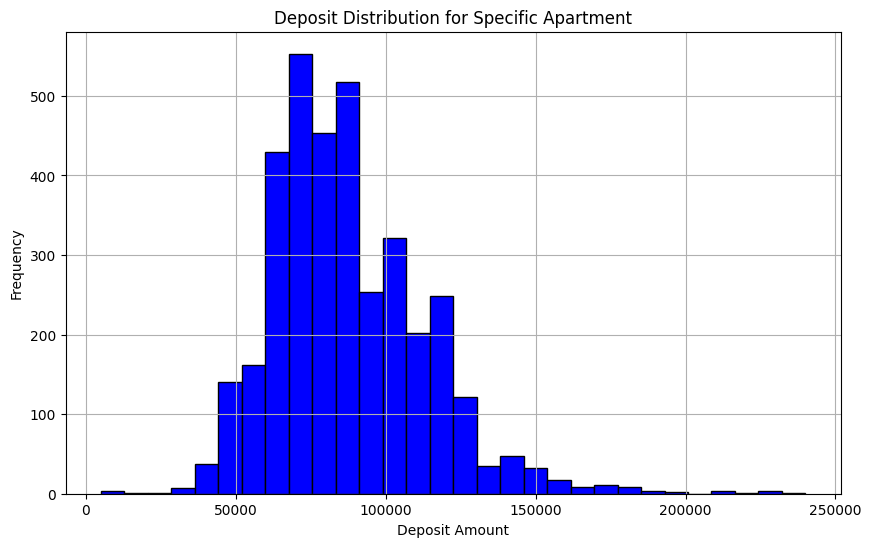

In [73]:
# Plotting deposit distribution
plt.figure(figsize=(10, 6))
plt.hist(specific_apartment_data['deposit'], bins=30, color='blue', edgecolor='black')
plt.title('Deposit Distribution for Specific Apartment')
plt.xlabel('Deposit Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [22]:
# 위도와 경도별로 그룹화하고 거래 횟수 계산
grouped_data = train_data.groupby(['latitude', 'longitude']).size().reset_index(name='transaction_count')

# 거래 횟수 통계량 확인
transaction_stats = grouped_data['transaction_count'].describe()

# 결과 출력
transaction_stats



count    18491.000000
mean        92.889027
std        181.975762
min          1.000000
25%          5.000000
50%         24.000000
75%        104.000000
max       5013.000000
Name: transaction_count, dtype: float64

In [26]:
# 위도와 경도별로 그룹화하여 거래 횟수와 deposit의 고유 값 개수 계산
grouped_data = train_data.groupby(['latitude', 'longitude']).agg(
    transaction_count=('deposit', 'size'),
    unique_deposit_count=('deposit', 'nunique')
).reset_index()

# 거래 횟수가 100 이상이고 deposit의 고유 값이 10 이하인 그룹 필터링
filtered_apartments = grouped_data[
    (grouped_data['transaction_count'] >= 100) & 
    (grouped_data['unique_deposit_count'] <= 10)
]

# 결과 출력
filtered_apartments


latitude   longitude  transaction_count  unique_deposit_count
7746   37.491584  126.948370                137                     6
12929  37.551909  127.181488                117                     2
13912  37.570434  127.170025                311                     9
13919  37.570577  127.173350                278                    10
14273  37.577819  126.882814                200                     9
16051  37.620699  127.166239                680                     4
16277  37.627512  127.148699                542                     4

In [39]:
# 위도와 경도에서 고유한 값 추출
unique_locations = train_data[['latitude', 'longitude']].drop_duplicates()

# 지도 중심 설정 (고유 위치들의 평균 위도, 경도를 사용)
map_center = [unique_locations['latitude'].mean(), unique_locations['longitude'].mean()]

# folium 지도 생성
m = folium.Map(location=map_center, zoom_start=12)

# MarkerCluster 생성
marker_cluster = MarkerCluster().add_to(m)

# 고유한 위도와 경도에 마커 추가 (MarkerCluster로 그룹화)
for idx, row in unique_locations.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(marker_cluster)

# 지하철 데이터 마커 추가 (지하철 위치 700개 추가)
for idx, row in subway_data.iterrows():
    folium.Marker([row['latitude'], row['longitude']], 
                  icon=folium.Icon(color='red', icon='train'), 
                  popup="Subway").add_to(m)

# 지도 렌더링
display(m)




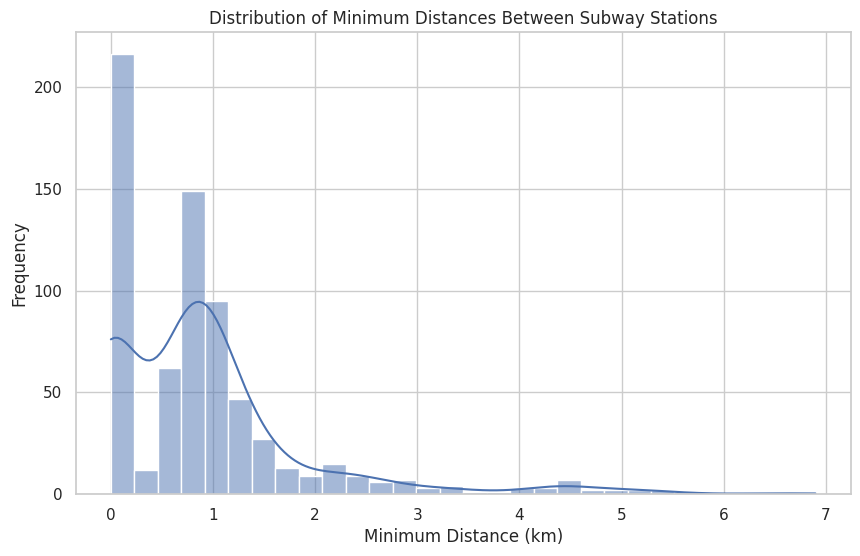

count    700.000000
mean       0.901193
std        1.034896
min        0.000000
25%        0.000000
50%        0.784611
75%        1.104860
max        6.897843
dtype: float64


In [41]:
# 각 지하철역에서 다른 지하철역까지의 최소 거리를 계산
min_distances = []

for i in range(len(subway_data)):
    current_station = (subway_data.loc[i, 'latitude'], subway_data.loc[i, 'longitude'])
    min_distance = float('inf')  # 초기값으로 매우 큰 값을 설정
    
    for j in range(len(subway_data)):
        if i != j:  # 자신과의 거리는 계산하지 않음
            other_station = (subway_data.loc[j, 'latitude'], subway_data.loc[j, 'longitude'])
            distance = geodesic(current_station, other_station).kilometers
            if distance < min_distance:
                min_distance = distance
                
    # 최소 거리를 리스트에 추가
    min_distances.append(min_distance)

# 최소 거리 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(min_distances, bins=30, kde=True)
plt.title('Distribution of Minimum Distances Between Subway Stations')
plt.xlabel('Minimum Distance (km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 최소 거리 통계량 확인
min_distance_stats = pd.Series(min_distances).describe()

# 통계량 출력
print(min_distance_stats)